In [57]:
import torch
from torch.autograd import Variable
from collections import defaultdict
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time

import pandas as pd 
from IPython.display import display
import seaborn as sns

In [2]:
print(torch.__version__)

1.1.0


In [3]:
fname = "../datasets/google_local/users.clean.json"
users_fname = "../datasets/google_local/users.cvs"

i = 0
for l in open(fname):
    i += 1
    if i < 10:
        data = eval(l)
    else:
        break
    
    print(data['gPlusUserId'],data['currentPlace'] )
    # print(data)

100000010817154263736 ['Thành phố Hồ Chí Minh, Việt Nam', [[], 108230990, 1066296640, 1]]
100000013500285534661 ['Adana', [[], 370000000, 353213330, 1]]
100000021336848867366 None
100000030557048145331 None
100000032416892623125 None
100000035085750632094 ['Pomona, CA', [[], 340552270, -1177523050, 1]]
100000036174088924566 None
100000037905537879319 None
100000039815955317902 None


In [4]:
fname = "../datasets/google_local/places.clean.json"
users_fname = "../datasets/google_local/places.cvs"

i = 0
for l in open(fname):
    i += 1
    if i < 10:
        data = eval(l)
    else:
        break
    
    print(data['gPlusPlaceId'],data['gps'] )
    # print(data)

104699454385822125632 [33.703804, -117.003209]
103054478949000078829 [38.979759, -76.547538]
109810290098030327104 [43.22776, 44.762726]
100327153115986850675 [43.529494, -96.792244]
103368487323937936043 [-2.976256, 104.742662]
103903929544828620241 [48.767817, 8.75612]
103848836623683146185 [37.576427, -101.386182]
114537653478141145113 [1.572255, 110.362958]
100062881646354125752 [35.224978, 139.088382]


## Extract ('PlaceId','UserId','rating,'Time') --> reviews.csv

In [5]:
fname = "../datasets/google_local/reviews.clean.json"
review_fname = "../datasets/google_local/reviews.csv"

reviews = open(review_fname, 'w')
reviews.write('gPlusPlaceId' + ',' + 'gPlusUserId' + ',' + 'rating'+ ',' + 'unixReviewTime' + '\n')

for l in open(fname):
    data = eval(l)
    reviews.write(data['gPlusPlaceId'] +','+ data['gPlusUserId'] +','+ str(data['rating'])  + ','+ \
                      str(data['unixReviewTime']) + '\n')
reviews.close()

In [5]:
places = pd.read_csv("../datasets/google_local/reviews.csv")
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11453845 entries, 0 to 11453844
Data columns (total 4 columns):
gPlusPlaceId      object
gPlusUserId       object
rating            float64
unixReviewTime    object
dtypes: float64(1), object(3)
memory usage: 349.5+ MB


In [6]:
places.head()

,gPlusPlaceId,gPlusUserId,rating,unixReviewTime
0,108103314380004200232,100000010817154263736,3.0,1372686659
1,102194128241608748649,100000013500285534661,5.0,1342870724
2,101409858828175402384,100000021336848867366,5.0,1390653513
3,101477177500158511502,100000021336848867366,5.0,1389187706
4,106994170641063333085,100000021336848867366,4.0,1390486279


## Rating Distribution

In [33]:
print(list(places['rating'].unique()))
print(list(places['rating'].value_counts()))

[3.0, 5.0, 4.0, 2.0, 1.0, 0.0]
[5722956, 2689692, 1510797, 921153, 609203, 44]


count    1.145384e+07
mean     4.047326e+00
std      1.195725e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

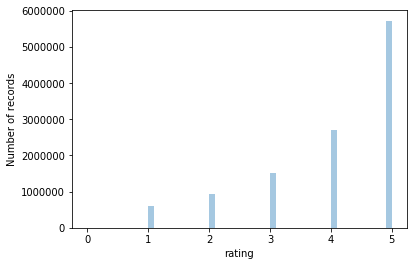

<function matplotlib.pyplot.show>

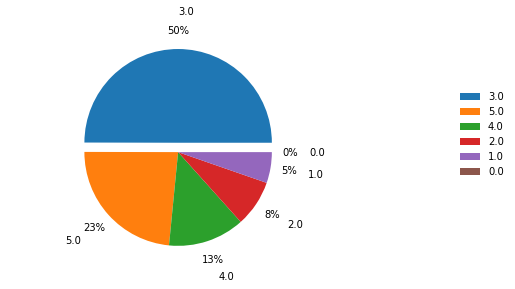

In [32]:
display(places['rating'].describe())

sns.distplot(places['rating'],kde=False)
plt.ylabel('Number of records')
plt.show()


labels = list(places['rating'].unique())
percentages = list(places['rating'].value_counts())
explode=(0.1,0,0,0,0,0)
plt.pie(percentages, explode=explode, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
plt.axis('equal')
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show

In [8]:
places['gPlusPlaceId'].describe()

count                  11453845
unique                  3116785
top       118197036100848201903
freq                       1662
Name: gPlusPlaceId, dtype: object

In [9]:
places['gPlusUserId'].describe()

count                  11453845
unique                  5054567
top       100689039355298728862
freq                       3221
Name: gPlusUserId, dtype: object

In [6]:
place_ids = places['gPlusPlaceId'].unique()
print(len(place_ids))

user_ids = places['gPlusUserId'].unique()
print(len(user_ids))

3116785
5054567


## Review Freq - Places

In [48]:
freq = places['gPlusPlaceId'].value_counts()

In [49]:
freq[:10]

118197036100848201903    1662
113708963026857003945     982
107836749011706685871     790
114299893842663642400     663
105221456964199450690     653
104102841184199673397     639
106603537575677448372     602
111652147815121544598     572
110471016000628728985     531
107596156349032509891     530
Name: gPlusPlaceId, dtype: int64

count    3.116785e+06
mean     3.674891e+00
std      7.308351e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.662000e+03
Name: gPlusPlaceId, dtype: float64

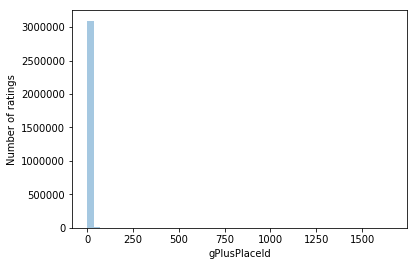

In [50]:
display(freq.describe())

sns.distplot(place_freq,kde=False)
plt.ylabel('Number of ratings')
plt.show()


In [62]:
verylow_review = freq[freq <= 5]

print(len(verylow_review))

low_review = freq[freq > 5][freq <= 10]

print(len(low_review))

high_review = freq[freq > 10]

print(len(high_review))

2624231
306479
186075


### Majority Places - 5 or less Reviews

<function matplotlib.pyplot.show>

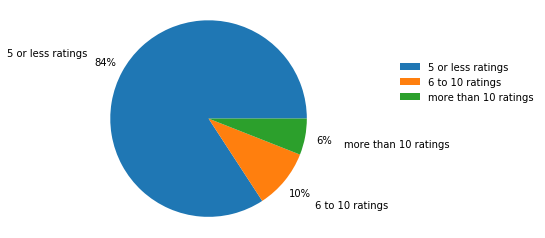

In [67]:
labels = [
    '5 or less ratings', 
    "6 to 10 ratings", 
    "more than 10 ratings"
]

percentages = [
    len(verylow_review), 
    len(low_review), 
    len(high_review) 
]


plt.pie(percentages, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
plt.axis('equal')
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show


In [86]:
very_unpopular = list(verylow_review.index)
unpopular = list(low_review.index)
popular = list(high_review.index)

print(len(very_unpopular))
print(len(unpopular))
print(len(popular))

2624231
306479
186075


count    4.059520e+06
mean     4.154573e+00
std      1.106464e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

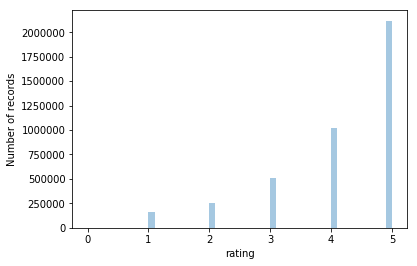

<function matplotlib.pyplot.show>

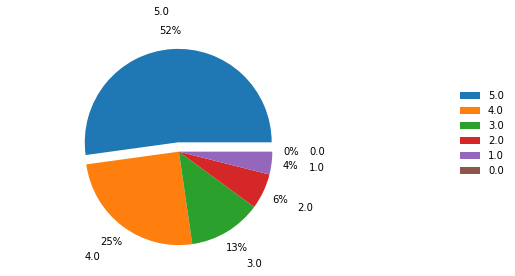

In [84]:
popular_places = places[places['gPlusPlaceId'].isin(popular)]

display(popular_places['rating'].describe())

sns.distplot(popular_places['rating'],kde=False)
plt.ylabel('Number of records')
plt.show()

counts = popular_places['rating'].value_counts()
labels = []
percentages = []
for index, count in counts.items() :
    labels.append(index)
    percentages.append(count)

explode=(0.1,0,0,0,0,0)
plt.pie(percentages, explode=explode, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
plt.axis('equal')
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show

count    2.283467e+06
mean     4.007662e+00
std      1.221795e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

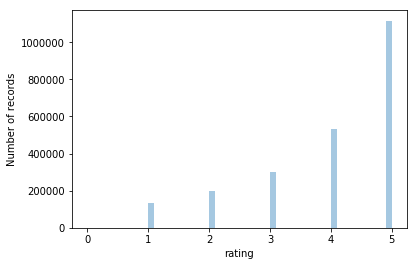

<function matplotlib.pyplot.show>

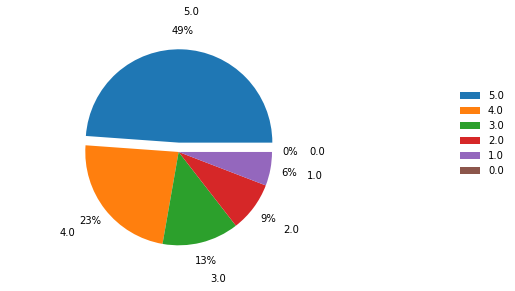

In [83]:
unpopular_places = places[places['gPlusPlaceId'].isin(unpopular)]


display(unpopular_places['rating'].describe())

sns.distplot(unpopular_places['rating'],kde=False)
plt.ylabel('Number of records')
plt.show()

counts = unpopular_places['rating'].value_counts()
labels = []
percentages = []
for index, count in counts.items() :
    labels.append(index)
    percentages.append(count)

explode=(0.1,0,0,0,0,0)
plt.pie(percentages, explode=explode, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
plt.axis('equal')
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show

count    5.110858e+06
mean     3.979862e+00
std      1.245166e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

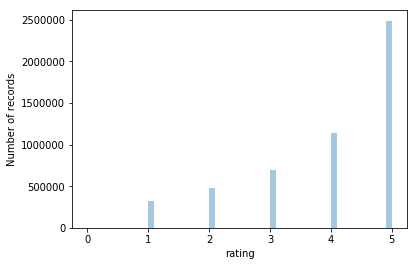

<function matplotlib.pyplot.show>

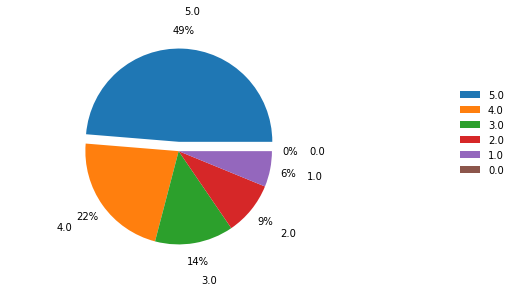

In [88]:
veryunpopular_places = places[places['gPlusPlaceId'].isin(very_unpopular)]

display(veryunpopular_places ['rating'].describe())

sns.distplot(veryunpopular_places ['rating'],kde=False)
plt.ylabel('Number of records')
plt.show()

counts = veryunpopular_places['rating'].value_counts()
labels = []
percentages = []
for index, count in counts.items() :
    labels.append(index)
    percentages.append(count)

explode=(0.1,0,0,0,0,0)
plt.pie(percentages, explode=explode, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
plt.axis('equal')
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show

## Less Popular Places - Lower Rating



In [20]:
review_pop_places = places[places['gPlusPlaceId'].isin(popular)]

review_pop_places.head()

,gPlusPlaceId,gPlusUserId,rating,unixReviewTime
20,110484732624327291509,100000036174088924566,5.0,1388050006
24,114222269311366452319,100000042779388982190,2.0,1372840159
26,104231480695579463827,100000050936341836015,5.0,1362944666
33,110058017192925236130,100000062743976665256,3.0,1380378214
34,101223243259821862422,100000064326457959539,2.0,1381887379


In [54]:
review_pop_places.to_csv (r'../datasets/google_local/popPlaces.cvs', index = None, header=True)

In [21]:
review_unpop_places = places[places['gPlusPlaceId'].isin(unpopular)]

review_unpop_places.head()

,gPlusPlaceId,gPlusUserId,rating,unixReviewTime
0,108103314380004200232,100000010817154263736,3.0,1372686659
1,102194128241608748649,100000013500285534661,5.0,1342870724
2,101409858828175402384,100000021336848867366,5.0,1390653513
3,101477177500158511502,100000021336848867366,5.0,1389187706
4,106994170641063333085,100000021336848867366,4.0,1390486279


In [24]:
unpopularRating_mean = review_unpop_places['rating'].mean()

print(unpopularRating_mean)

3.9884472213488045


In [26]:
unpopularRating_median = review_unpop_places['rating'].median()

print(unpopularRating_median)

4.0


In [22]:
popularRating_mean = review_pop_places['rating'].mean()

print(popularRating_mean)

4.154573200772505


In [23]:
popularRating_median = review_pop_places['rating'].median()

print(popularRating_median)

5.0


## Temporal Analysis

In [45]:
places = pd.read_csv("../datasets/google_local/reviews_freq.csv")
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11453845 entries, 0 to 11453844
Data columns (total 5 columns):
gPlusPlaceId      int64
gPlusUserId       int64
rating            float64
unixReviewTime    object
num_reviews       int64
dtypes: float64(1), int64(3), object(1)
memory usage: 436.9+ MB


### Remove reviews with no Time

In [47]:
# Get names of indexes for which column unixReviewTime has value 'None'
indexNames = places[places["unixReviewTime"]=='None'].index
 
# Delete these row indexes from dataFrame
places.drop(indexNames , inplace=True)

In [50]:
places_timed = places.astype('int32')

In [51]:
places_timed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10601852 entries, 0 to 11453842
Data columns (total 5 columns):
gPlusPlaceId      int32
gPlusUserId       int32
rating            int32
unixReviewTime    int32
num_reviews       int32
dtypes: int32(5)
memory usage: 283.1 MB


### Review Period: 12/1990 - 2/2014

In [89]:
Begin = time.gmtime(places_timed["unixReviewTime"].min())
BeginStruct = time.strftime("%d %b %Y, %I:%M:%S", Begin)

print(places_timed["unixReviewTime"].min(), BeginStruct)

662601600 31 Dec 1990, 12:00:00


In [93]:
End = time.gmtime(places_timed["unixReviewTime"].max())
EndStruct = time.strftime("%d %b %Y, %I:%M:%S", End)

print(places_timed["unixReviewTime"].max(), EndStruct)

1396082360 29 Mar 2014, 08:39:20


### Most reviews - After 1-1-2012

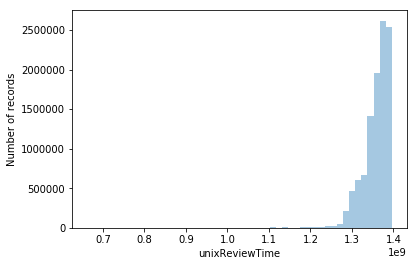

In [58]:
sns.distplot(places_timed["unixReviewTime"],kde=False)
plt.ylabel('Number of records')
plt.show()

In [107]:
Dates = ["1-1-2010","1-1-2011","1-1-2012","1-1-2013","1-1-2014"]

def unix_time(date):
    timeStruct = time.strptime(date, "%d-%m-%Y")
    timeInt = time.mktime(timeStruct)
    return timeInt

total = len(places_timed.index)

for date in Dates:
    
    print("Before {} ({:d})".format(date,int(unix_time(date))))
    num_reviews = len(places_timed[places_timed["unixReviewTime"]<unix_time(date)].index)
    print("Num Reviews={}, ({:.5f})".format(num_reviews, num_reviews/total))
    print("\n")

num_reviews = len(places_timed[places_timed["unixReviewTime"]>=unix_time("1-1-2014")].index)
print("After {} ({:d})".format(date,int(unix_time("1-1-2014"))))
print("Num Reviews={}, ({:.5f})".format(num_reviews, num_reviews/total))

Before 1-1-2010 (1262332800)
Num Reviews=89769, (0.00847)


Before 1-1-2011 (1293868800)
Num Reviews=366902, (0.03461)


Before 1-1-2012 (1325404800)
Num Reviews=1526510, (0.14399)


Before 1-1-2013 (1357027200)
Num Reviews=4050530, (0.38206)


Before 1-1-2014 (1388563200)
Num Reviews=9239560, (0.87150)


After 1-1-2014 (1388563200)
Num Reviews=1362292, (0.12850)


In [94]:
places_timed.sort_values(by=["unixReviewTime"])

,gPlusPlaceId,gPlusUserId,rating,unixReviewTime,num_reviews
4615709,804813,2021440,4,662601600,9
897140,1918972,389663,4,662601600,20
6175469,449452,2709545,4,662601600,15
11192629,942354,4936600,4,662601600,293
1898989,3063673,828378,5,662601600,11
3605223,2437018,1575245,5,662601600,55
4608639,1005238,2018339,4,662601600,18
6175479,729337,2709545,5,662601600,7
6175480,737152,2709545,5,662601600,5
375399,2778756,165149,5,662601600,21


In [102]:
timeStruct = time.gmtime(1396078950)

year, month, day = map(int,time.strftime("%Y %m %d",timeStruct).split())

print(year, month, day)

2014 3 29
